In [1]:
import numpy as np
import math
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from financepy.models.black import *
from financepy.utils.global_types import *
import Fourier as fourier
import MJD as mjd

%load_ext autoreload
%autoreload 2

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [2]:
def blackImpliedVol(forward,   # Forward rate F
                    K,         # Strike Rate K
                    T,         # Time to Expiry (years)
                    DF,        # df RFR to expiry date
                    callOrPut, # FinOptionTypes.EUROPEAN_CALL or FinOptionTypes.EUROPEAN_PUT
                    price
                    ):    
    min_ivol, max_ivol = 0.001, 1.0
    f = lambda ivol: Black(ivol).value(forward, K, T, DF, callOrPut) - price    
    return optimize.bisect(f, min_ivol, max_ivol)    

In [3]:
# vol is volatility
# Y is the jump size, log Y ~ N(a, b^2)
# lam is the intensity of the Poisson process
# T is the maturity
def MertonJumpDiffusionCall(S0, K, rfr, vol, a, b, lam, T):    
    ns = np.arange(40)    
    J_bar = np.exp(a + 0.5 * b * b)
    m = J_bar - 1    
    lam_p = lam * (1 + m)
    lam_p_T = lam_p * T   
    
    weights_ns =  [pow(lam_p_T, n)/math.factorial(n) for n in ns]
    
    v_sq_ns = [vol*vol + b*b*n/T for n in ns]
    v_ns = np.sqrt(v_sq_ns)    
    r_ns = [rfr - lam*m + n*np.log(1+m)/T for n in ns]
    callOrPut = OptionTypes.EUROPEAN_CALL    
    
    calls = [w_n * Black(v_n).value(S0*np.exp(r_n*T), K, T, np.exp(-r_n*T), callOrPut) for w_n, v_n, r_n in zip(weights_ns, v_ns, r_ns)]
    
    return np.exp(-lam_p_T) * sum(calls)

### Different maturities

Text(0, 0.5, 'Lognormal Implied Volatility')

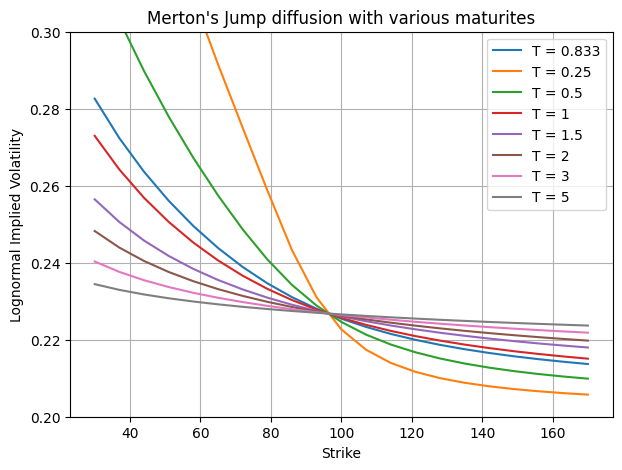

In [4]:
S0 = 100
Ts = [0.833, 3/12, 1/2, 1, 1.5, 2, 3, 5]
r = 0
vol = 0.2; lam = 0.5; a = -0.15; b = 0.05
Ks = np.linspace(30, 170, 21)
callOrPut = OptionTypes.EUROPEAN_CALL

df = pd.DataFrame()
df['Strike'] = Ks
for T in Ts:    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    fourier_MJD_call_values = [DF * fourier.carr_madan_MJD_call_option(forward, vol, a, b, lam, T, K) for K in Ks]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(fourier_MJD_call_values, Ks)]       
    df['T = ' + str(T)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Merton's Jump diffusion with various maturites")
plt.ylim((0.2, 0.3))
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigMJD1.png")

### Different lambda

Text(0, 0.5, 'Lognormal Implied Volatility')

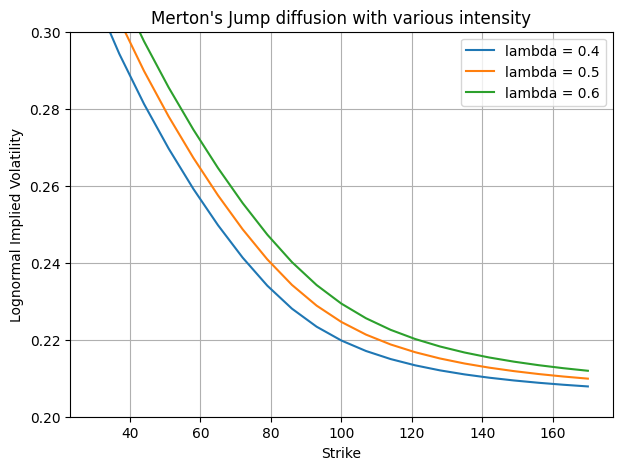

In [5]:
S0 = 100
T = 1/2
r = 0
forward = S0 * np.exp(r*T)
vol = 0.2; a = -0.15; b = 0.05
lams = [0.4, 0.5, 0.6]
DF = np.exp(-r*T)
callOrPut = OptionTypes.EUROPEAN_CALL

Ks = np.linspace(30, 170, 21)
df = pd.DataFrame()
df['Strike'] = Ks
for lam in lams:
    fourier_MJD_call_values = [fourier.carr_madan_MJD_call_option(forward, vol, a, b, lam, T, K) for K in Ks]  
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(fourier_MJD_call_values, Ks)]       
    df['lambda = ' + str(lam)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Merton's Jump diffusion with various intensity")
plt.ylim((0.2, 0.3))
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigMJD2.png")

### Different vol

Text(0, 0.5, 'Lognormal Implied Volatility')

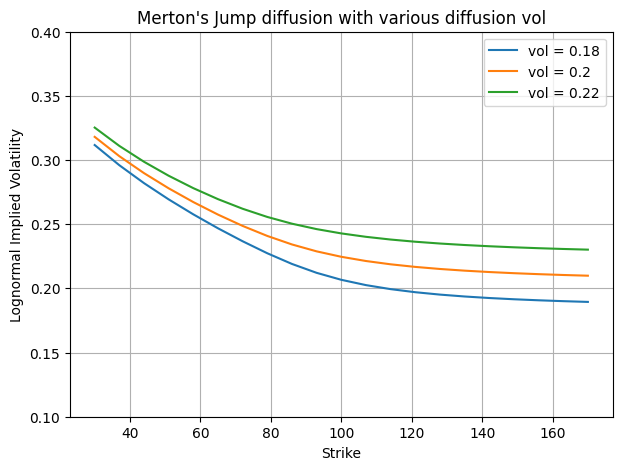

In [6]:
S0 = 100
T = 1/2
r = 0
forward = S0 * np.exp(r*T)
lam = 0.5; a = -0.15; b = 0.05
vols = [0.18, 0.2, 0.22]
DF = np.exp(-r*T)
callOrPut = OptionTypes.EUROPEAN_CALL

Ks = np.linspace(30, 170, 21)
df = pd.DataFrame()
df['Strike'] = Ks
for vol in vols:
    fourier_MJD_call_values = [fourier.carr_madan_MJD_call_option(forward, vol, a, b, lam, T, K) for K in Ks]  
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(fourier_MJD_call_values, Ks)]       
    df['vol = ' + str(vol)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Merton's Jump diffusion with various diffusion vol")
plt.ylim((0.1, 0.4))
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigMJD3.png")

### Different a

Text(0, 0.5, 'Lognormal Implied Volatility')

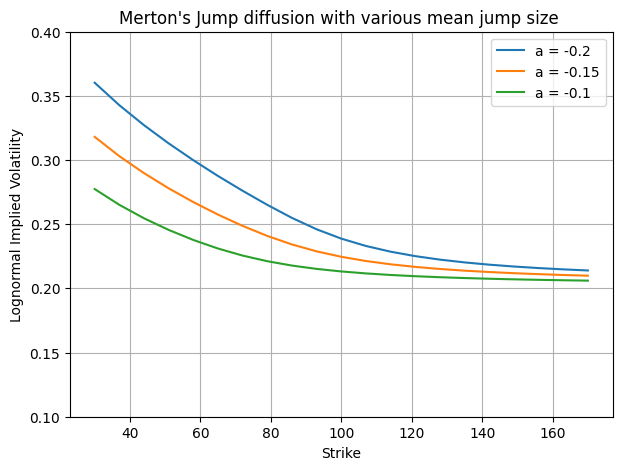

In [7]:
S0 = 100
T = 1/2
r = 0
forward = S0 * np.exp(r*T)
vol = 0.2; lam = 0.5; b = 0.05
a_s = [-0.2, -0.15, -0.1]
DF = np.exp(-r*T)
callOrPut = OptionTypes.EUROPEAN_CALL

Ks = np.linspace(30, 170, 21)
df = pd.DataFrame()
df['Strike'] = Ks
for a in a_s:
    fourier_MJD_call_values = [fourier.carr_madan_MJD_call_option(forward, vol, a, b, lam, T, K) for K in Ks]  
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(fourier_MJD_call_values, Ks)]       
    df['a = ' + str(a)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Merton's Jump diffusion with various mean jump size ")
plt.ylim((0.1, 0.4))
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigMJD4.png")

### Different b

Text(0, 0.5, 'Lognormal Implied Volatility')

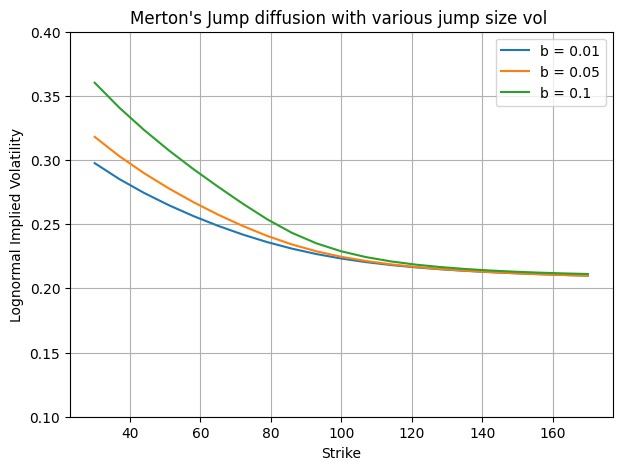

In [8]:
S0 = 100
T = 1/2
r = 0
forward = S0 * np.exp(r*T)
vol = 0.2; lam = 0.5; a = -0.15; b = 0.05
b_s = [0.01, 0.05, 0.10]
DF = np.exp(-r*T)
callOrPut = OptionTypes.EUROPEAN_CALL

Ks = np.linspace(30, 170, 21)
df = pd.DataFrame()
df['Strike'] = Ks
for b in b_s:
    fourier_MJD_call_values = [fourier.carr_madan_MJD_call_option(forward, vol, a, b, lam, T, K) for K in Ks]  
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(fourier_MJD_call_values, Ks)]       
    df['b = ' + str(b)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Merton's Jump diffusion with various jump size vol ")
plt.ylim((0.1, 0.4))
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigMJD5.png")

### Fourier MJD vs Closed Form MJD


Text(0, 0.5, 'Abs Difference in ivol')

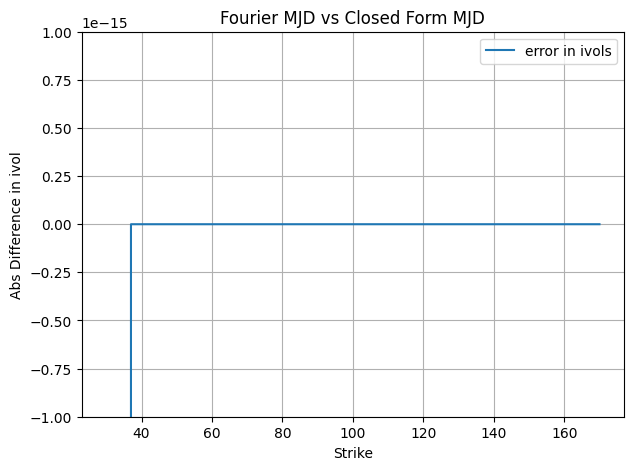

In [9]:
S0 = 100
Ts = 1
r = 0.05
q = 0
forward = S0 * np.exp(r*T)
vol = 0.5; lam = 1; a = -0.3; b = 0.2
DF = np.exp(-r*T)
callOrPut = OptionTypes.EUROPEAN_CALL

Ks = np.linspace(30, 170, 21)
df = pd.DataFrame()

df['Strike'] = Ks
  
DF = np.exp(-r*T)
forward = S0 * np.exp(r*T)        

MJD_closedforms = [mjd.QF602MJDCall(S0, K, r, q, vol, a, b, lam, T) for K in Ks]
MJD_ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(MJD_closedforms, Ks)]   

df['mjd price'] = np.array(MJD_closedforms)
df['mjd ivol'] = np.array(MJD_ivols)

ft_call_values = [DF * fourier.carr_madan_MJD_call_option(forward, vol, a, b, lam, T, K) for K in Ks]   
ft_ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(ft_call_values, Ks)]
df['ft price'] = np.array(ft_call_values)
df['ft ivol'] = np.array(ft_ivols)

df['error in ivols'] = df['ft ivol'] - df['mjd ivol']
    

#df = df.set_index('Strike')
df.plot(x='Strike', y='error in ivols', grid=True, figsize=(7, 5))
plt.ylim(-1E-15, 1E-15)
plt.title("Fourier MJD vs Closed Form MJD")
plt.xlabel("Strike")
plt.ylabel("Abs Difference in ivol")

#plt.savefig("L4_FigMJD6.png")

In [10]:
df['error in ivols']

0    -3.634315e-12
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     0.000000e+00
5     0.000000e+00
6     0.000000e+00
7     0.000000e+00
8     0.000000e+00
9     0.000000e+00
10    0.000000e+00
11    0.000000e+00
12    0.000000e+00
13    0.000000e+00
14    0.000000e+00
15    0.000000e+00
16    0.000000e+00
17    0.000000e+00
18    0.000000e+00
19    0.000000e+00
20    0.000000e+00
Name: error in ivols, dtype: float64